In [50]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"
batch_size = 32
image_size = (224, 224)

# Reduced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,  # Reduced rotation
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  # Reduced shifts
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [52]:
# Build VGG16 Model with Additional Dense Layer
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=num_classes, fine_tune_at=10):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Add Classification Head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Learning Rate Scheduler
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
    )

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model


In [53]:
# # Plotting function
# def plot_training_results(history, metrics=["accuracy", "loss"]):
#     for metric in metrics:
#         plt.figure()
#         plt.plot(history.history[metric], label=f"Training {metric}")
#         plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
#         plt.title(f"Training vs Validation {metric.capitalize()}")
#         plt.xlabel("Epochs")
#         plt.ylabel(metric.capitalize())
#         plt.legend()
#         plt.show()

In [54]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Initial Training
model, base_model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=num_classes)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 1362s 7s/step - accuracy: 0.4104 - loss: 1.5264 - val_accuracy: 0.5359 - val_loss: 1.1464 - learning_rate: 9.1530e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1346s 7s/step - accuracy: 0.5670 - loss: 1.0940 - val_accuracy: 0.6083 - val_loss: 1.0151 - learning_rate: 6.8989e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1329s 7s/step - accuracy: 0.6184 - loss: 0.9863 - val_accuracy: 0.6274 - val_loss: 0.9647 - learning_rate: 4.0015e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1322s 7s/step - accuracy: 0.6341 - loss: 0.9598 - val_accuracy: 0.6376 - val_loss: 0.9474 - learning_rate: 1.4424e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1333s 7s/step - accuracy: 0.6410 - loss: 0.9392 - val_accuracy: 0.6376 - val_loss: 0.9468 - learning_rate: 8.8663e-06
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1323s 7s/step - accuracy: 0.6418 - loss: 0.9426 - val_accuracy: 0.6382 - val_loss: 0.9472 - learning_rate: 1.0000e-08
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1050s 6s/step - accurac

In [55]:
# plot_training_results(history, metrics=["accuracy", "loss"])


In [56]:
# Fine-tune the Base Model
base_model.trainable = True
for layer in base_model.layers[:10]:  # Freeze only first 10 layers
    layer.trainable = False

# Recompile with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning Training
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1232s 7s/step - accuracy: 0.6576 - loss: 0.9252 - val_accuracy: 0.6776 - val_loss: 0.8474 - learning_rate: 1.0000e-05
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.7000 - loss: 0.8086 - val_accuracy: 0.6734 - val_loss: 0.8665 - learning_rate: 1.0000e-05
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1231s 7s/step - accuracy: 0.7198 - loss: 0.7673 - val_accuracy: 0.6932 - val_loss: 0.8043 - learning_rate: 1.0000e-05
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1234s 7s/step - accuracy: 0.7427 - loss: 0.7282 - val_accuracy: 0.7183 - val_loss: 0.7512 - learning_rate: 1.0000e-05
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.7451 - loss: 0.6850 - val_accuracy: 0.7219 - val_loss: 0.7387 - learning_rate: 1.0000e-05
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1242s 7s/step - accuracy: 0.7576 - loss: 0.6734 - val_accuracy: 0.7398 - val_loss: 0.6962 - learning_rate: 1.0000e-05
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/ste

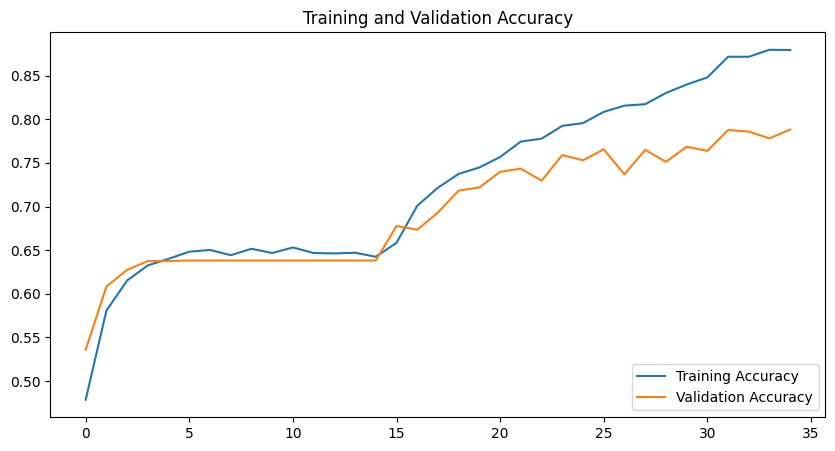

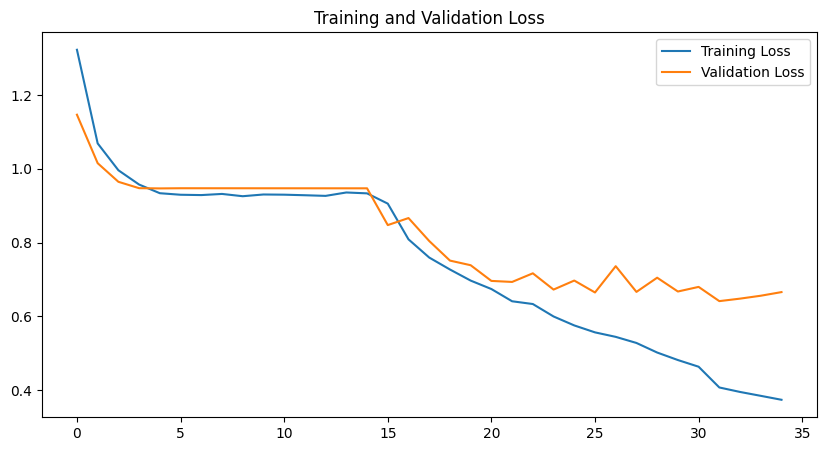

In [57]:
# Plot Training and Validation Accuracy
def plot_training_results(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history, fine_tune_history)


In [58]:
# Save the trained model
model.save("../../models/Improved_vgg16_model.keras")